In [550]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [551]:
df_kickstarter = pd.read_csv('ks-projects-201801.csv')

In [552]:
df_kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [553]:
df_kickstarter.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [554]:
df_kickstarter.head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


### 各列の意味を確認
- ID: internal kickstarter id (kickstaterのID)
- name: name of project (プロジェクトの名前)
- category: category (プロジェクトのカテゴリ)
- main_category: category of campaign (キャンペーンのカテゴリ)
- currency: currency used to support (サポートに使われた通貨)
- deadline: deadline of crowdfunding (クラウドファンディングの締め切り日)
- goal: fundraising goal (支援金の目標)
- launched: data launced (クラウドファンディングの立ち上げ日)
- pledged: amount pledged by "crowd" (クラウドファンディングによって得られた金額)
- state: Current condition the project is in (プロジェクトの現在の状況)
- backers: number of backers (支援者の数)
- country: country pledged from (どの国から支援を受けたか)
- usd pledged: Pledged amount in USD (conversion made by KS) (支援金額(USD))
- usd_pledged_real: Pledged amount in USD (conversion made by fixer.io api) (支援金額(USD))
- usd_goal_real: Goal amount in USD (目標金額(USD)

- pledged, backers, country, usd pledged, usd_pledged_realはプロジェクト終了後に得られるデータのためstateの予測に使うことはできない.
- ID, nameはstateに直接関係しないと考えられる．
- launchedとdeadlineは単独ではあまり意味をなさないが，２つの差をとって得られるプロジェクトの期間はstateに関係がありそう．

### 各変数の個数を見ていく

In [555]:
df_kickstarter['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

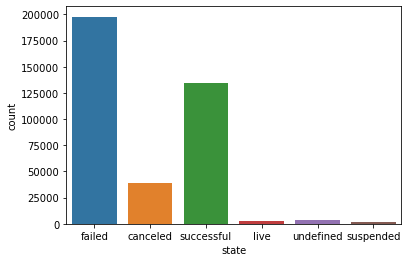

In [556]:
sns.countplot(df_kickstarter["state"])

- 予測したいsuccessfulとfailed以外にもクラスがあるので，他のクラスのデータは後で削除する.

In [557]:
df_kickstarter['category'].value_counts()

Product Design     22314
Documentary        16139
Music              15727
Tabletop Games     14180
Shorts             12357
                   ...  
Residencies           69
Letterpress           49
Chiptune              35
Literary Spaces       27
Taxidermy             13
Name: category, Length: 159, dtype: int64

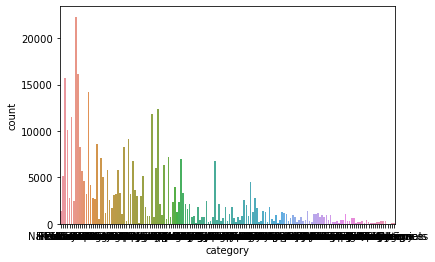

In [558]:
sns.countplot(df_kickstarter["category"])

- カテゴリが159個に分けられている.
- １番大きい値のProduct Designの22314に対して，1番小さい値がTaxidermyの13とかなり小さい.

In [559]:
df_kickstarter['main_category'].value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

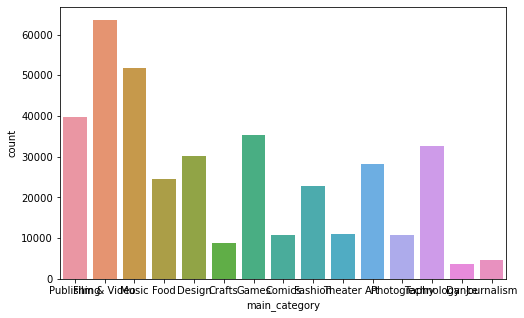

In [560]:
plt.figure(figsize=(8, 5))
sns.countplot(df_kickstarter["main_category"])

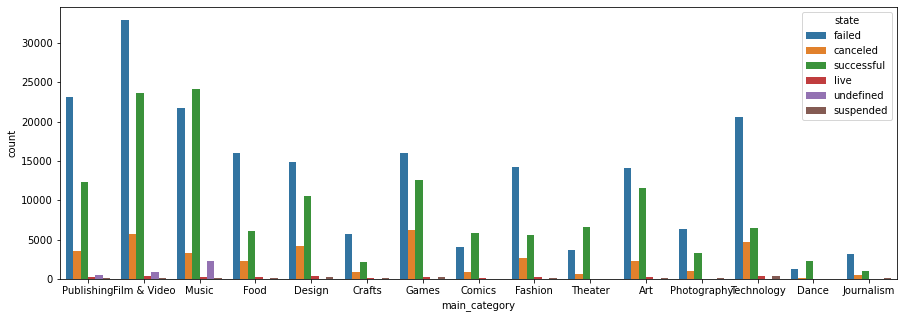

In [561]:
plt.figure(figsize=(15, 5))
sns.countplot(df_kickstarter["main_category"], hue=df_kickstarter['state'])

- main_categoryは15に分類されて，特別小さい値もない．
- main_categoryの中にcategoryの情報が入っていると考えて，main_categoryのみを説明変数として使う．

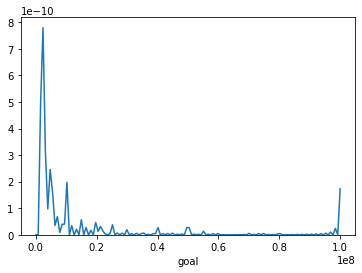

In [562]:
# goalについて
sns.distplot(df_kickstarter["goal"], hist=False)

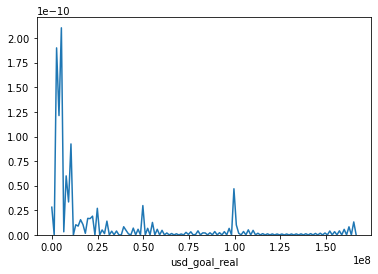

In [563]:
sns.distplot(df_kickstarter["usd_goal_real"], hist=False)

count    3.786610e+05
mean     4.545440e+04
std      1.152950e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.550000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

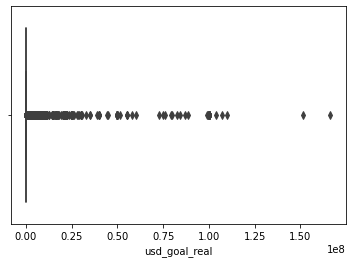

In [564]:
sns.boxplot(df_kickstarter["usd_goal_real"])
df_kickstarter["usd_goal_real"].describe()

(0.0, 50000.0)

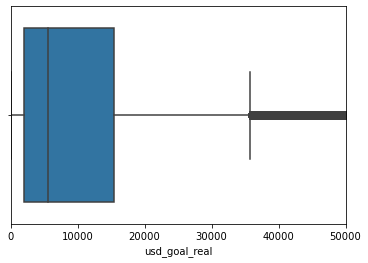

In [565]:
sns.boxplot(df_kickstarter["usd_goal_real"])
plt.xlim([0, 5e4])

- 両者とも単位が異なるだけで似た振る舞いをしている．
- 今回はusd_goal_realを使う.ただし，後で外れ値をNoneに置き換える．

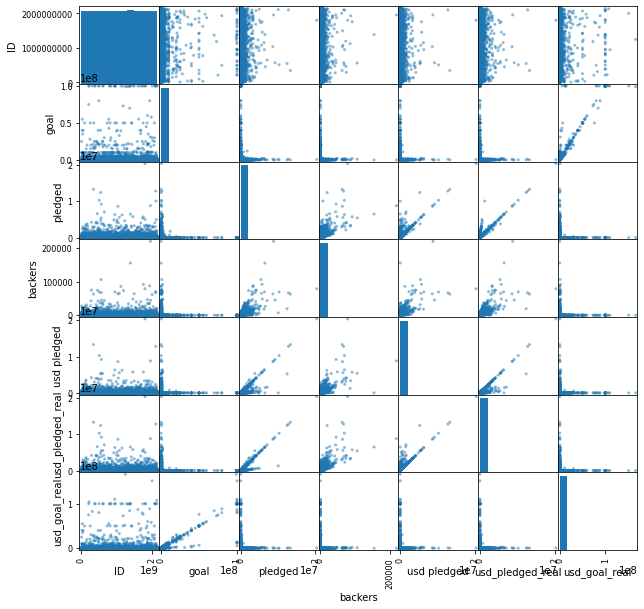

In [566]:
# 確認のため散布図行列を作成
pd.plotting.scatter_matrix(df_kickstarter, figsize = (10, 10))
plt.show()

## 各変数に関してのまとめ

- 説明変数: main_category, usd_goal_real, プロジェクトの期間

- 目的変数: state(successful, failedのみ)

- 説明変数のmain_categoryはダミー変数に変換.deadlineからlaunchedを引いて期間を計算.目的変数のstateはsuccessfulを1に，failedを0にして残りは削除．

# 前処理

In [567]:
# stateのsuccessful, failed以外は後で削除するのでNoneにしておく

df_kickstarter.loc[df_kickstarter["state"] == "successful", "state"] = 1
df_kickstarter.loc[df_kickstarter["state"] == "failed", "state"] = 0
df_kickstarter.loc[df_kickstarter["state"] == "canceled", "state"] = None
df_kickstarter.loc[df_kickstarter["state"] == "live", "state"] = None
df_kickstarter.loc[df_kickstarter["state"] == "undefined", "state"] = None
df_kickstarter.loc[df_kickstarter["state"] == "suspended", "state"] = None

df_kickstarter["state"].value_counts()

0    197719
1    133956
Name: state, dtype: int64

In [568]:
# プロジェクトの期間の計算
import datetime
from datetime import timedelta

print(df_kickstarter["launched"].dtypes)
print(type(df_kickstarter["launched"][0]))

df_kickstarter["deadline"] = pd.to_datetime(df_kickstarter["deadline"])
df_kickstarter["launched"] = pd.to_datetime(df_kickstarter["launched"])

print(df_kickstarter["launched"].dtypes)

df_kickstarter["period"] = df_kickstarter["deadline"] - df_kickstarter["launched"]

object
<class 'str'>
datetime64[ns]


In [569]:
df_kickstarter["period"].head()

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
4   55 days 15:24:57
Name: period, dtype: timedelta64[ns]

In [570]:
# 日数のみに興味があるのでdaysの単位に変換してroundで丸め込む
df_kickstarter["period"] = round(df_kickstarter["period"] / timedelta(days=1))

In [571]:
df_kickstarter.head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,0,0,GB,0.00,0.00,1533.95,58.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,0,15,US,100.00,2421.00,30000.00,60.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,0,3,US,220.00,220.00,45000.00,45.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,0,1,US,1.00,1.00,5000.00,30.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,None,14,US,1283.00,1283.00,19500.00,56.0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,1,224,US,52375.00,52375.00,50000.00,34.0
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,1,16,US,1205.00,1205.00,1000.00,19.0
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,0,40,US,453.00,453.00,25000.00,44.0
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,None,58,US,8233.00,8233.00,125000.00,34.0
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,None,43,US,6240.57,6240.57,65000.00,29.0


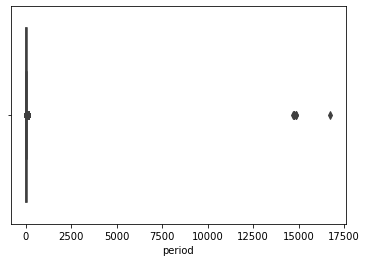

In [572]:
# 期間の外れ値がないか確認
sns.boxplot(df_kickstarter["period"])

count    378661.000000
mean         33.858462
std          65.916045
min           0.000000
25%          29.000000
50%          30.000000
75%          37.000000
max       16739.000000
Name: period, dtype: float64

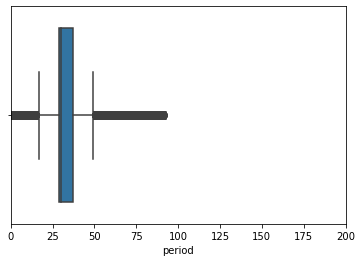

In [573]:
# 期間の外れ値がないか確認
sns.boxplot(df_kickstarter["period"])
plt.xlim([0, 200])
df_kickstarter["period"].describe()

- 明らかな外れ値があるのでそれらはNoneにする．100以下はありうる値なのでそのままにする．

In [574]:
df_kickstarter.loc[df_kickstarter["period"] > 100, "period"] = None

count    378654.000000
mean         33.580749
std          12.815043
min           0.000000
25%          29.000000
50%          30.000000
75%          37.000000
max          92.000000
Name: period, dtype: float64

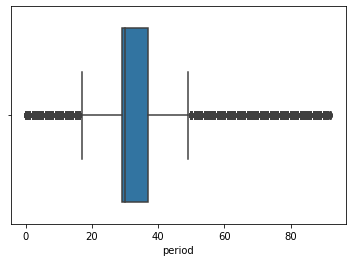

In [575]:
sns.boxplot(df_kickstarter["period"])
df_kickstarter["period"].describe()

In [576]:
df_kickstarter["period"].value_counts()

29.0    109807
30.0     70939
59.0     21600
60.0     13471
44.0     11540
         ...  
81.0        52
82.0        50
78.0        47
73.0        45
92.0        11
Name: period, Length: 93, dtype: int64

- 期間を0\~18, 19\~30, 31\~50, 51\~92でグルーピング

In [577]:
df_kickstarter["period_band"] = pd.cut(df_kickstarter["period"], [0, 18, 30, 51, 92], labels=range(4), right=False)

In [578]:
df_kickstarter["period_band"].value_counts()

2    155329
1    153401
3     46795
0     23118
Name: period_band, dtype: int64

(0.0, 50000.0)

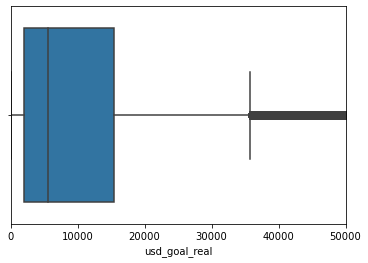

In [579]:
# usd_goal_realについても外れ値をNoneにして，グルーピングをしていく
sns.boxplot(df_kickstarter["usd_goal_real"])
plt.xlim([0, 5e4])

count    333802.000000
mean       7714.211951
std        8191.375349
min           0.010000
25%        1746.300000
50%        5000.000000
75%       10000.000000
max       36999.000000
Name: usd_goal_real, dtype: float64

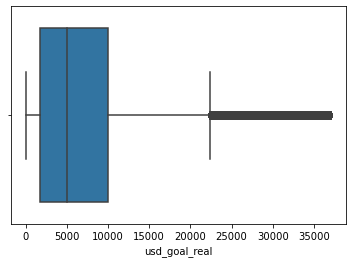

In [580]:
# 37000以上をNoneにする．
df_kickstarter.loc[df_kickstarter["usd_goal_real"] >= 37000, "usd_goal_real"] = None
sns.boxplot(df_kickstarter["usd_goal_real"])
df_kickstarter["usd_goal_real"].describe()

In [581]:
df_kickstarter["usd_goal_real_band"] = pd.cut(df_kickstarter["usd_goal_real"], [0, 1800, 5000, 10000, 37000], labels=range(4), right=False)

In [582]:
df_kickstarter["usd_goal_real_band"].value_counts()

3    100344
0     84136
1     78473
2     70849
Name: usd_goal_real_band, dtype: int64

In [583]:
# category, main_category, currencyをダミー変数で置き換え
dummy_main_category = pd.get_dummies(df_kickstarter["main_category"])

df_kickstarter = pd.concat([df_kickstarter, dummy_main_category], axis=1)

In [584]:
df_kickstarter.head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,0,...,0,0,0,0,0,0,0,1,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,0,...,0,1,0,0,0,0,0,0,0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,0,...,0,1,0,0,0,0,0,0,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,0,...,0,0,0,0,0,1,0,0,0,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,None,...,0,1,0,0,0,0,0,0,0,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,1,...,0,0,1,0,0,0,0,0,0,0
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,1,...,0,0,1,0,0,0,0,0,0,0
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,0,...,0,0,1,0,0,0,0,0,0,0
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,None,...,0,0,0,0,0,0,0,0,0,0
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,None,...,0,1,0,0,0,0,0,0,0,0


In [585]:
df_kickstarter.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'period',
       'period_band', 'usd_goal_real_band', 'Art', 'Comics', 'Crafts', 'Dance',
       'Design', 'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism',
       'Music', 'Photography', 'Publishing', 'Technology', 'Theater'],
      dtype='object')

In [586]:
drop_list = ['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'launched', 'pledged', 
             'country', 'usd pledged', 'usd_pledged_real', 'goal', 'backers']
df_kickstarter = df_kickstarter.drop(drop_list, axis=1)
df_kickstarter = df_kickstarter.dropna()

In [587]:
df_kickstarter.head()

,state,usd_goal_real,period,period_band,usd_goal_real_band,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,0,1533.95,58.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,30000.00,60.0,3,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,5000.00,30.0,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,1,1000.00,19.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,0,25000.00,44.0,2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [588]:
# bandを使わないで予測

y = df_kickstarter["state"].values.astype(int)
X = df_kickstarter.drop(["state", "period_band", "usd_goal_real_band"], axis=1).values

clf = SGDClassifier(loss="log", penalty="none", max_iter=100000,
                   fit_intercept=True, random_state=1234, tol=1e-3)

clf.fit(X, y)
y_est = clf.predict(X)
y_est_proba = clf.predict_proba(X)
print("対数尤度 = {:.3f}".format(-log_loss(y, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y, y_est)))

対数尤度 = -4068354.312
正答率 = 59.701%


In [589]:
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

# precision, recall, f1を計算
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

,予測値 = failed,予測値 = successful
正解 = failed,91553,76166
正解 = successful,42998,84986


適合率（Precision） = 52.737%
再現率（Recall） = 66.404%
F1値（F1-score） = 58.786%


In [590]:
# bandを使って予測

y = df_kickstarter["state"].values.astype(int)
X = df_kickstarter.drop(["state", "period", "usd_goal_real"], axis=1).values

clf = SGDClassifier(loss="log", penalty="none", max_iter=100000,
                   fit_intercept=True, random_state=1234, tol=1e-3)

clf.fit(X, y)
y_est = clf.predict(X)
y_est_proba = clf.predict_proba(X)
print("対数尤度 = {:.3f}".format(-log_loss(y, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y, y_est)))

対数尤度 = -192055.433
正答率 = 62.285%


In [591]:
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

# precision, recall, f1を計算
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

,予測値 = failed,予測値 = successful
正解 = failed,123612,44107
正解 = successful,67418,60566


適合率（Precision） = 57.862%
再現率（Recall） = 47.323%
F1値（F1-score） = 52.065%


# まとめ
## 前処理
- 説明変数に適さないものを削除した.
- launchedとdeadlineを使ってプロジェクトの期間(period)を算出．
- usd_goal_real, periodの外れ値を除外し，グルーピング(bandの作成)した．

## モデルの考案と予測
- 分類問題のため，ロジスティック回帰(正則化なし)を用いた．
- bandで束ねる前と後で予測の結果がどのようにaccuracy, precision, recall, f1-scoreが変化するか調べた．

## 結果
### bandで束ねる前のデータを用いてstateがsuccessful, failedになるかを予測した結果.
- 正答率(accuracy) = 59.701%
- 適合率（Precision） = 52.737%
- 再現率（Recall） = 66.404%
- F1値（F1-score） = 58.786%

### bandで束ねた後のデータを用いてstateがsuccessful, failedになるかを予測した結果.
- 正答率(accuracy) = 62.285%
- 適合率（Precision） = 57.862%
- 再現率（Recall） = 47.323%
- F1値（F1-score） = 52.065%

## 考察
- bandを作ることで各値のノルムが均一になり，予測結果も上昇したと考えられる．しかし，bandで束ねる前のデータに対して標準化することで同様の結果が得られるとも考えられる．

In [592]:
df_kickstarter.to_csv("ks-projects-201801_day1.csv")